## инициализация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option("display.max_rows", 50)  # показывать больше строк
pd.set_option("display.max_columns", 50)  # показывать больше колонок

students = pd.read_csv("stud_math.csv")

### первый взгляд

In [2]:
display(students.head(10))
display(students.info())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

None

## предобработка


In [3]:
# меняем название одного столбца и переводим заголовки в нижний регистр
students.rename(columns={"studytime, granular": "studytime_gr"}, inplace=True)
students.columns = [name.lower() for name in students.columns]

### вспомогательные функции

In [4]:
def text_to_code(value, dictionary):
    """convert text choiser to code based on provided dict
    return: None or int
    """
    if type(value) == str:
        if len(value) == 0:
            return None
    elif type(value) == float:
        if np.isnan(value):
            return None
    return dictionary[value]


def get_outliers(column_name):
    """calculate outliers for column
    return: hight and low thresholds
    """
    iqr = students[column_name].quantile(0.75) - students[column_name].quantile(0.25)
    perc25 = students[column_name].quantile(0.25)
    perc75 = students[column_name].quantile(0.75)
    print(f"25-й перцентиль: {perc25}")
    print(f"75-й перцентиль: {perc75}")
    print(f"IRQ: {iqr}")
    print(f"Границы выбросов: [{perc25 - 1.5*iqr}, {perc75 + 1.5*iqr}]")
    print(f"Границы значений: [{students[column_name].min()}, {students[column_name].max()}]")
    return [perc25 - 1.5 * iqr, perc75 + 1.5 * iqr]


def fill_nan_weighted(column_name):
    """fill empty cells with weighted cell values
    return: nothing, just True
    """
    total_not_nan = students[column_name].notna().sum()
    # list of indexes of nan cells
    nan_index_list = students[students[column_name].isnull()].index.to_list()
    # sorted by count dict of value:not_nan_count elements
    weighted_dict = students[column_name].value_counts().sort_values(ascending=False).to_dict() 

    # changing absolute not_nan_count to weighted count. how many times we shold put value in order to keep original disrtibution
    for value, count in weighted_dict.items():
        weighted_dict[value] = round(len(nan_index_list) * count / total_not_nan)

    # forming list which will replace NaN
    weighted_list = []
    for value, weight in weighted_dict.items():
        weighted_list += [value] * weight

    # check if due to 'round' we got unequal lists
    len_diff = len(nan_index_list) - len(weighted_list)
    if len_diff > 0:
        # if elements are lost, just add most weighted value in order to aligne lists
        weighted_list += [list(weighted_dict.keys())[0]] * len_diff
    elif len_diff < 0:
        # if got extra elements, just cut off less significant values
        weighted_list = weighted_list[:len_diff]
    
    # shuffling
    np.random.seed(2021)
    np.random.shuffle(weighted_list)
    np.random.shuffle(nan_index_list)
    # replace NaN to weighted list
    students.loc[nan_index_list, column_name] = weighted_list
    return True


def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(
            students.loc[students.loc[:, column] == comb[0], "score"],
            students.loc[students.loc[:, column] == comb[1], "score"],
        ).pvalue <= 0.05 / len(
            combinations_all
        ):  # Учли поправку Бонферони
            print("Найдены статистически значимые различия для колонки", column)
            break

# choice sets
school = {"GP": 1, "MS": 2}
sex = {"F": 1, "M": 2}
address = {"U": 1, "R": 2}
famsize = {"LE3": 1, "GT3": 2}
pstatus = {"A": 1, "T": 2}
job = {"at_home": 1, "health": 2, "services": 3, "teacher": 4, "other": 5}
reason = {"course": 1, "home": 2, "reputation": 3, "other": 4}
guardian = {"mother": 1, "father": 2, "other": 3}
yes_no = {"yes": 1, "no": 0}
text_to_code_dict = {
    "school": school,
    "sex": sex,
    "address": address,
    "famsize": famsize,
    "pstatus": pstatus,
    "mjob": job,
    "fjob": job,
    "reason": reason,
    "guardian": guardian,
    "schoolsup": yes_no,
    "famsup": yes_no,
    "paid": yes_no,
    "activities": yes_no,
    "nursery": yes_no,
    "higher": yes_no,
    "internet": yes_no,
    "romantic": yes_no,
}

## обработка

In [5]:
# посмотрим на уникальные значения
for column, value in students.items():
    print(f"{column:>15}: {value.unique()}")

         school: ['GP' 'MS']
            sex: ['F' 'M']
            age: [18 17 15 16 19 22 20 21]
        address: ['U' nan 'R']
        famsize: [nan 'GT3' 'LE3']
        pstatus: ['A' nan 'T']
           medu: [ 4.  1.  3.  2. nan  0.]
           fedu: [ 4.  1.  2.  3. 40. nan  0.]
           mjob: ['at_home' 'health' 'other' 'services' 'teacher' nan]
           fjob: ['teacher' 'other' nan 'health' 'services' 'at_home']
         reason: ['course' 'other' 'home' 'reputation' nan]
       guardian: ['mother' 'father' 'other' nan]
     traveltime: [ 2.  1.  3. nan  4.]
      studytime: [ 2.  3.  1. nan  4.]
       failures: [ 0.  3. nan  2.  1.]
      schoolsup: ['yes' 'no' nan]
         famsup: ['no' 'yes' nan]
           paid: ['no' nan 'yes']
     activities: ['no' 'yes' nan]
        nursery: ['yes' 'no' nan]
   studytime_gr: [ -6.  -9.  -3.  nan -12.]
         higher: ['yes' nan 'no']
       internet: [nan 'yes' 'no']
       romantic: ['no' nan 'yes']
         famrel: [ 4.  5.  3. 

Что вижу при обзоре уникальных значений:
- пустые ячейки - меняем на None
- в fedu, скорее всего, опечатка, меняем 40 на 4
- в famrel, скорее всего опечатка, меняем -1 на 1
- только три параметра: age (под вопросом, но он и так числовой), score и absences принимают случайные значения, все остальные это выбор из словаря со предопределенными вариантами ответа, при этом часть данных представлена в виде номера ответа (типа studytime), а другая в виде текстового варианта ответа (типа famsize) - думаю все на числовой вариант перевести

In [6]:
# правим fudu и famrel
students.fedu = students.fedu.replace(40, 4)
students.famrel = students.famrel.replace(-1, 1)

# меняет текст на числовой код
for column in students.columns:
    if column in list(text_to_code_dict.keys()):
        code = text_to_code_dict[column]
        students[column] = students[column].apply(text_to_code, args=(code,))
    

score и absences единнственные, принимающие случайные значения, все остальные параметры это выбор из словаря готовых вариантов
 ответа (что делать с studytime_gr пока не известно). Проверим сколько пропусков и нулей в этих стобцах.

In [7]:
for column in ["score", "absences"]:
    nan = len(students[students[column].isnull()][column])
    zero = len(students[students[column] == 0])
    print(f"Пропуски в {column}: {nan}")
    print(f"Нулевые значения в {column}: {zero}")


Пропуски в score: 6
Нулевые значения в score: 37
Пропуски в absences: 12
Нулевые значения в absences: 111


- пропуски в score, думаю, заполнять не нужно, так как это цель нашего анализа, поэтому удалим их из выборки
- нулевые значения в score тоже вопрос, я бы сказал, что это либо какие-нибудь не допуски к экзамену, либо совсем безнадежные ученики, потенциально эту часть можно отделить от основного датасета
- пропуски в absences заполним после проверки на выбросы
- нулевые значения в absences - ок

In [8]:
# удаляем пропуски из score
students = students.loc[students.score.isna()==False]

In [9]:
# обрабатываем выбросы score и absences с сохранением nan
for column in ["score", "absences"]:
    print(f"\tПараметры для {column}")
    outliers_range = get_outliers(column)
    students = students.loc[
        (students[column].between(*outliers_range))
        | (students[column].isna())
    ]


	Параметры для score
25-й перцентиль: 40.0
75-й перцентиль: 70.0
IRQ: 30.0
Границы выбросов: [-5.0, 115.0]
Границы значений: [0.0, 100.0]
	Параметры для absences
25-й перцентиль: 0.0
75-й перцентиль: 8.0
IRQ: 8.0
Границы выбросов: [-12.0, 20.0]
Границы значений: [0.0, 385.0]


посмотрим на гистограммы score и absences

<Figure size 432x288 with 0 Axes>

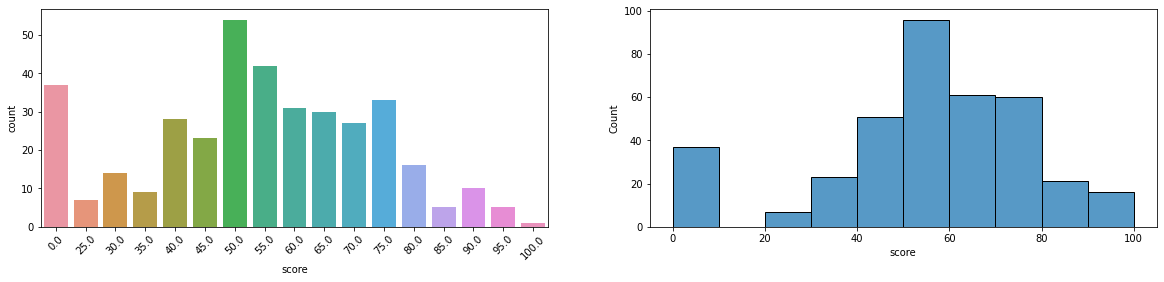

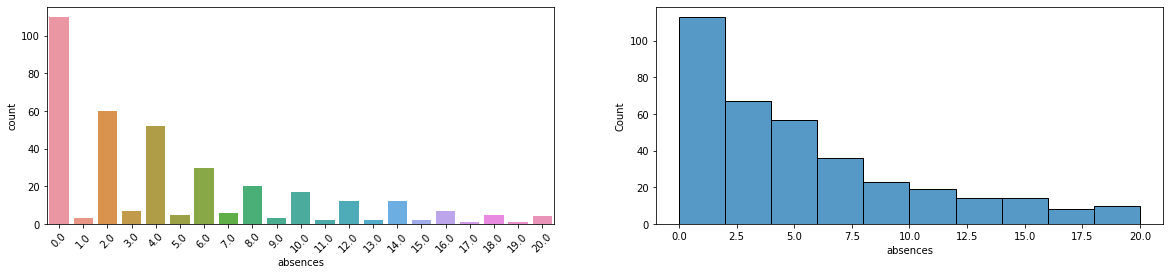

In [10]:
for i, column in enumerate(["score", "absences"]):
    plt.figure(i)
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    sns.countplot(x=column, data=students, ax=ax[0])
    sns.histplot(data=students[column], ax=ax[1], bins=10)
    plt.sca(ax[0])
    plt.xticks(rotation=45)
plt.show()

два, с моей точки зрения, интересных момента:
- нечетных пропусков гораздо меньше чем четных. Как объяснить и что с этим делать непонятно, поэтому оставлю как есть
- есть много измерений где балл=0, с одной стороны похоже на какой-то выброс, например не сдававшие экзамен вовсе/не допущенные, с другой стороны, возможно действительно минимальное число баллов 25 и всем, кто набрал меньше, ставили 0, из-за этого такой всплеск в нуле. Возможно решение неправильное, но дальше отбросим нулевые значения как выбросы.

In [11]:
# удаляем score = 0
students = students.loc[students.score!=0]

In [12]:
# посмотрим на количество пропусков по всем колонкам
total = students.score.count()
print(f"{'Total':>15}: 100.0%: {total}")
for column in students.columns:
    nan_count = len(students[students[column].isnull()][column])
    if nan_count:
        print(f"{column:>15}: {round(nan_count/total*100,1):>5}%: {nan_count}")
    

          Total: 100.0%: 335
        address:   4.2%: 14
        famsize:   6.6%: 22
        pstatus:  10.7%: 36
           medu:   0.6%: 2
           fedu:   6.0%: 20
           mjob:   4.5%: 15
           fjob:   9.3%: 31
         reason:   4.5%: 15
       guardian:   8.4%: 28
     traveltime:   6.9%: 23
      studytime:   2.1%: 7
       failures:   5.1%: 17
      schoolsup:   2.7%: 9
         famsup:   9.6%: 32
           paid:  10.4%: 35
     activities:   3.6%: 12
        nursery:   3.6%: 12
   studytime_gr:   2.1%: 7
         higher:   5.4%: 18
       internet:   8.4%: 28
       romantic:   8.4%: 28
         famrel:   6.9%: 23
       freetime:   1.8%: 6
          goout:   1.8%: 6
         health:   3.9%: 13
       absences:   3.0%: 10


возьмем топ 7 (пропущено 8% и выше) и построим матрицу корреляции для оценки влияния на score, если связь мала, то дополним все пропуски

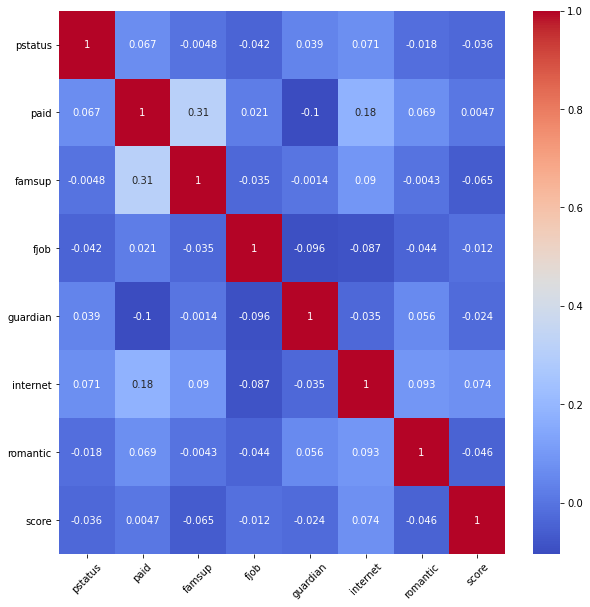

In [13]:
corr = students[
    ["pstatus", "paid", "famsup", "fjob", "guardian", "internet", "romantic", "score"]
].corr(method="pearson")
_, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=corr, annot=True, cmap="coolwarm", ax=ax)
_ = plt.yticks(rotation=0)
_ = plt.xticks(rotation=45)

с моей т.з. связь выбранных ячеек со score незначительная, поэтому равномерно заполним все пропуски

In [14]:
for collumn in students.columns:
    fill_nan_weighted(collumn)

построим тепловую карту на основе корреляции всех столбцов

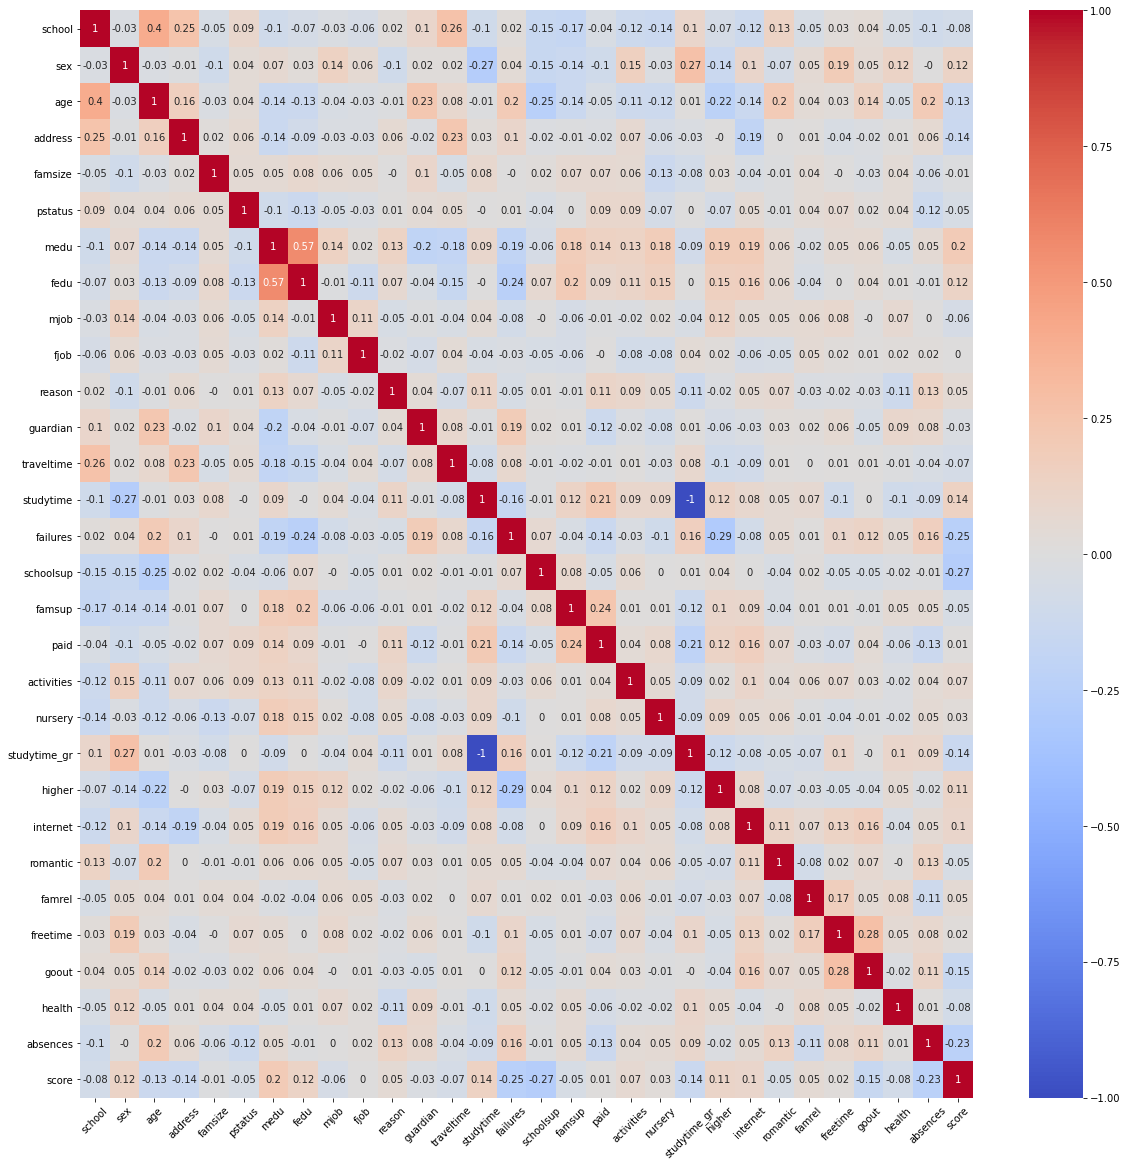

In [15]:
corr = students.corr(method="pearson").round(2)
_, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(data=corr, annot=True, cmap="coolwarm", ax=ax)
_ = plt.yticks(rotation=0)
_ = plt.xticks(rotation=45)

выводы по тепловой карте:
- корреляция studytime_gr и studytime равна -1, можно удалить studytime_gr, тем более все еще не известно, что это
- корреляция со score у всех низкая, но ниболее интересные параметры (>=0.2)
    - medu
    - failures
    - schoolsup
    - absences

построим серию boxplot'ов

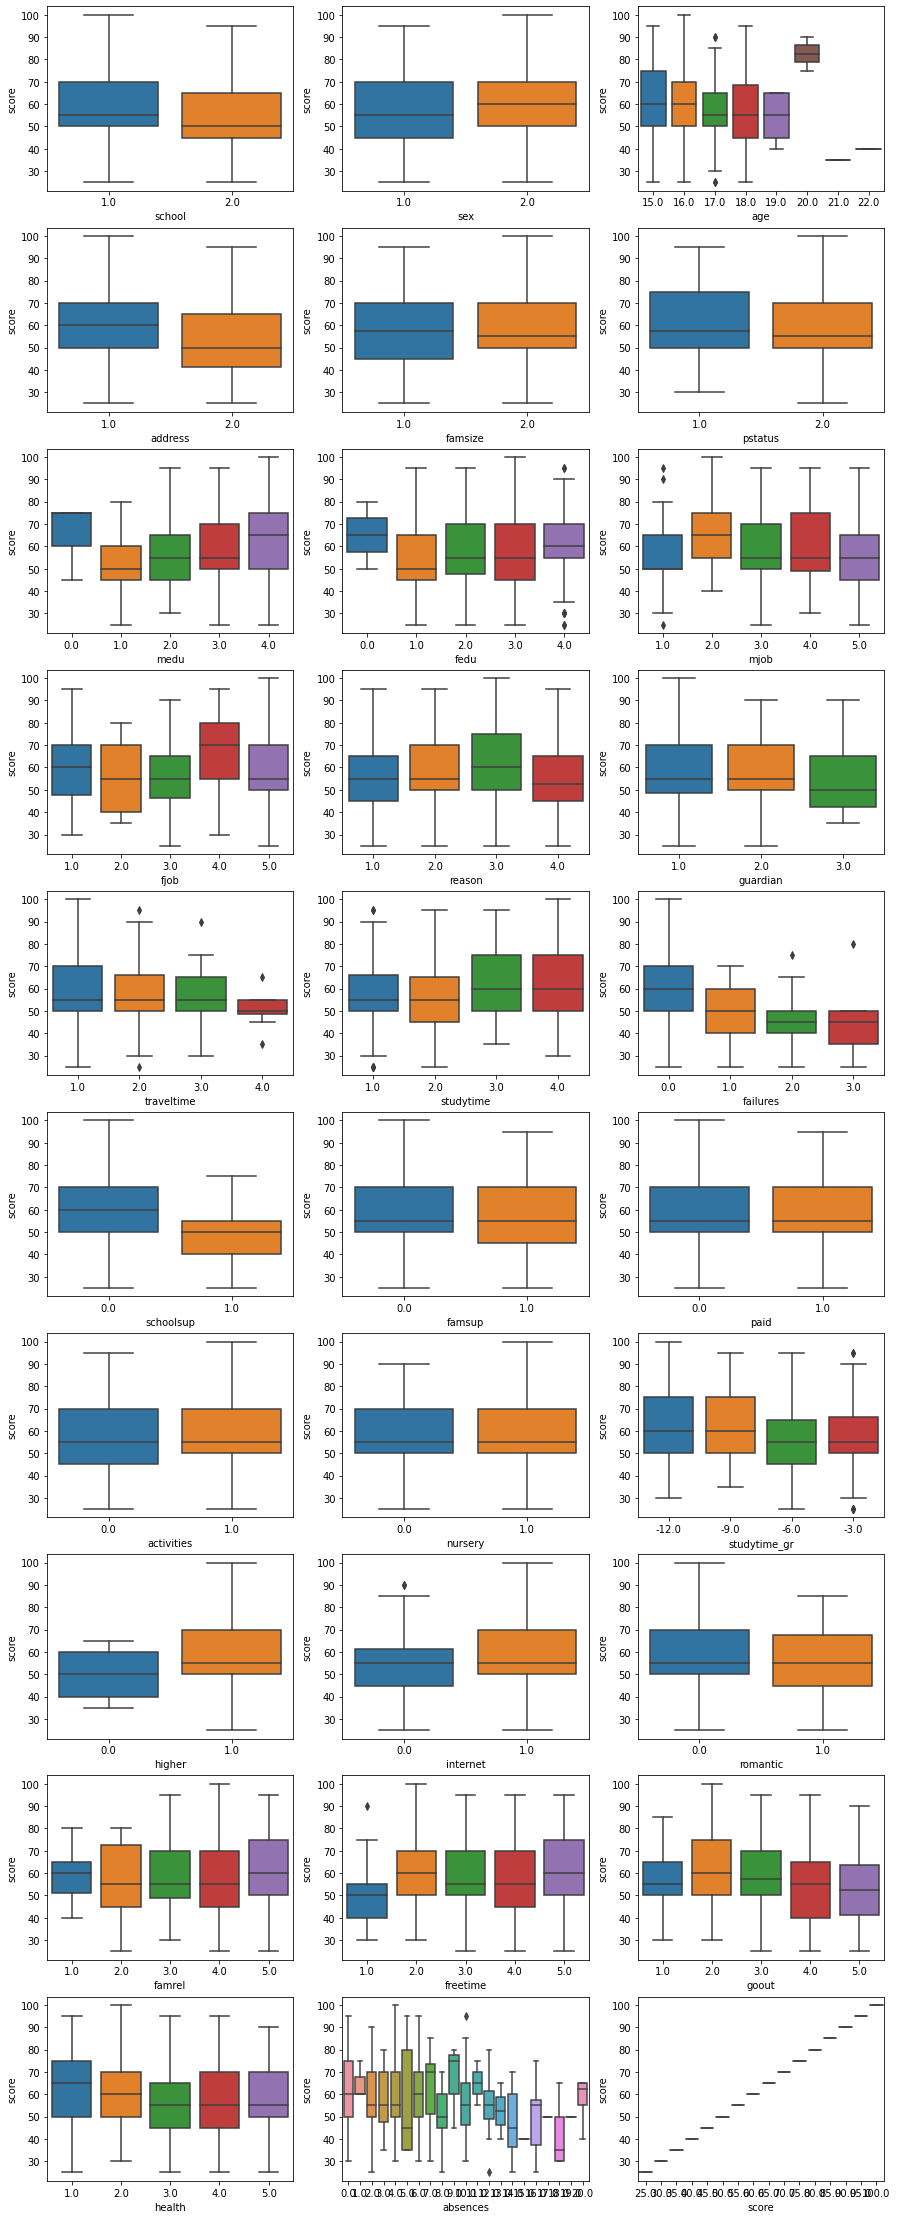

In [16]:
h_size = 3
v_size = 10
fig, axes = plt.subplots(v_size, h_size, figsize=(h_size * 5, v_size * 4))
h, v = 0, 0
for column in students.columns:
    sns.boxplot(
        x=column,
        y="score",
        data=students.loc[students.loc[:, column].isin(students.loc[:, column].value_counts().index)],
        ax=axes[v][h],
    )
    h += 1
    if h > h_size - 1:
        v += 1
        h = 0
plt.show()

тут аналогично, интересные параметры:
- medu/fedu
- mjob/fjob
- traveltime неожиданно )
- failures
- schoolsup
- higher
- absences

кандидаты на удаление:
- school
- sex
- famsize
- pstatus
- famsup
- paid
- activities
- nursery
- studytime_gr


В финале выполним тест Стьюдента

In [17]:
for column in students.loc[:, (students.columns != 'score') & (students.columns != 'age')].columns:
    get_stat_dif(column)


Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки fjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки studytime_gr
Найдены статистически значимые различия для колонки higher


Из предыдущих выводов выбивается sex, оставим его.

Итого удаляем:
- school
- famsize
- pstatus
- famsup
- paid
- activities
- nursery
- studytime_gr

Наиболее значимые критерии:
- medu
- mjob/fjob
- studytime
- traveltime
- failures
- schoolsup
- higher
- absences


In [18]:
column_to_delete = [
    "school",
    "famsize",
    "pstatus",
    "famsup",
    "paid",
    "activities",
    "nursery",
    "studytime_gr",
]
for column in column_to_delete:
    students.drop([column], inplace = True, axis = 'columns')

### Выводы

1. В данных были пустые значения, заполнили их (кроме score) с сохранением распределения.
2. Выбросы найдены только в столбце absences. Остальные значения из словаря, поэтому о чистоте данных сложно делать выводы.
3. Было много измерений с score=0, эти измерения были удалены, опять же правильно или нет, мне сложно сказать.
4. Наиболее важные параметры:
    - medu
    - mjob/fjob
    - studytime
    - traveltime
    - failures
    - schoolsup
    - higher
    - absences
